# 13강: 이미지 전처리와 데이터 증강

## 🎯 학습 목표
- 이미지 전처리 기법의 중요성과 다양한 방법 이해
- 데이터 증강(Data Augmentation)으로 모델 성능 향상
- 실제 데이터셋(CIFAR-10)에 전처리 기법 적용
- torchvision.transforms 활용법 완전 마스터

---

## 📚 강의 개요 (60분)
1. 이미지 전처리 기법 (20분)
2. 데이터 증강 기법 (20분)
3. CIFAR-10 실습 (20분)

> **이전 강의 복습**: 12강에서 MNIST로 MLP vs CNN 성능을 비교했습니다. 이제 더 복잡한 컬러 이미지를 다뤄보겠습니다!


## 1. 환경 설정 및 라이브러리 임포트


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 시드 설정으로 재현 가능한 결과 보장
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🚀 사용 디바이스: {device}')
if torch.cuda.is_available():
    print(f'🔥 GPU 이름: {torch.cuda.get_device_name(0)}')

print("✅ 환경 설정 완료!")


🚀 사용 디바이스: cuda
🔥 GPU 이름: NVIDIA GeForce RTX 4060 Ti
✅ 환경 설정 완료!


## 2. 이미지 전처리 기법

### 📖 왜 이미지 전처리가 중요할까요?

1. **🔧 일관성 확보**: 모든 이미지를 같은 크기와 형식으로 통일
2. **⚡ 학습 효율성**: 정규화로 학습 속도 향상 
3. **🎯 성능 향상**: 적절한 전처리로 모델 정확도 개선
4. **💾 메모리 효율**: 적절한 크기 조정으로 메모리 사용량 최적화

### 🛠️ 주요 전처리 기법들

| 기법 | 목적 | 예시 |
|------|------|------|
| **Resize** | 크기 통일 | 224×224로 조정 |
| **ToTensor** | 데이터 타입 변환 | PIL → Tensor |
| **Normalize** | 정규화 | 평균 0, 표준편차 1 |
| **CenterCrop** | 중앙 부분 자르기 | 정사각형으로 만들기 |
| **Pad** | 패딩 추가 | 테두리에 픽셀 추가 |


### 2.1 CIFAR-10 데이터셋 소개 및 로드

**📊 CIFAR-10 데이터셋 특징:**
- 10개 클래스의 컬러 이미지: 비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭
- 이미지 크기: 32×32×3 (RGB 컬러)
- 훈련용: 50,000개, 테스트용: 10,000개
- MNIST보다 훨씬 복잡한 실제 이미지


📊 CIFAR-10 훈련 데이터: 50000개
🏷️  클래스 개수: 10개
📏 이미지 크기: torch.Size([3, 32, 32])


/tmp/ipykernel_484934/3412129622.py:36: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_484934/3412129622.py:36: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_484934/3412129622.py:36: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_484934/3412129622.py:36: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_484934/3412129622.py:36: UserWarning: Glyph 47085 (\N{HANGUL SYLLABLE REOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_484934/3412129622.py:36: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_484934/3412129622.py:36: UserWarning: Glyph 49844 (\N{HANGUL SYLLABLE SEUM}) missing from font(s) DejaVu Sans.


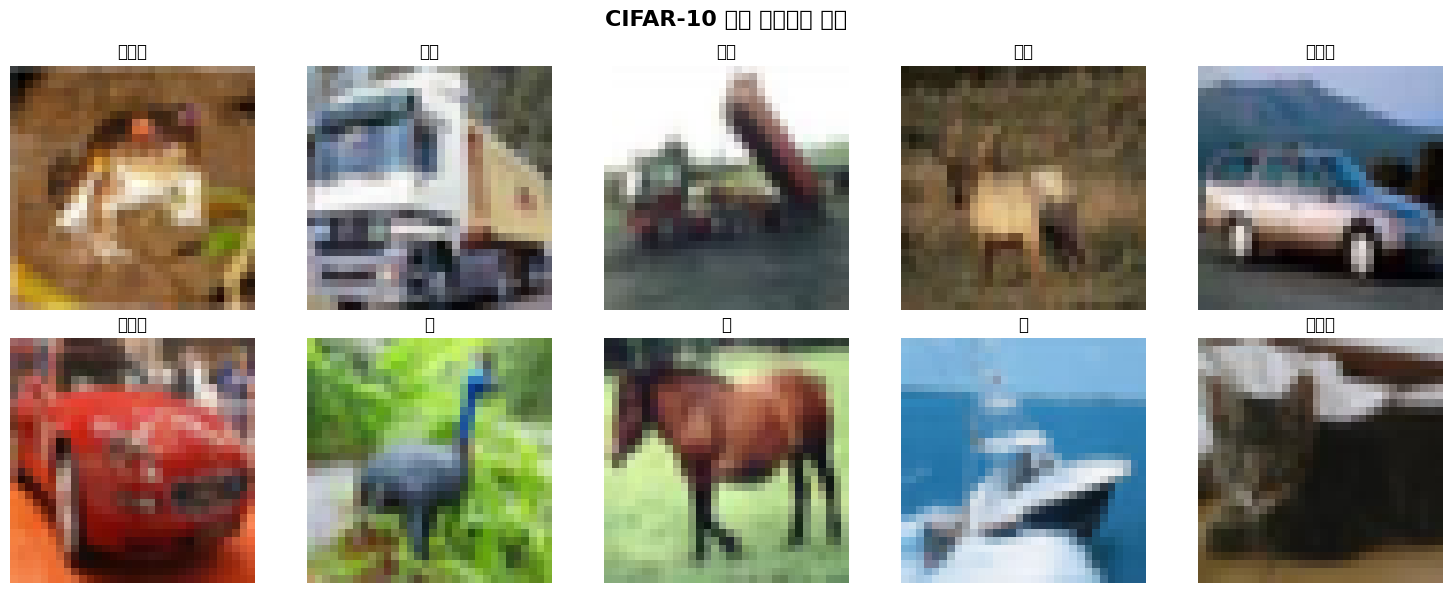

✅ 32×32 픽셀의 작은 이미지지만 다양한 객체들이 있네요!


In [3]:
# 🏷️ CIFAR-10 클래스 이름
cifar10_classes = ['비행기', '자동차', '새', '고양이', '사슴', 
                   '개', '개구리', '말', '배', '트럭']

# 📥 원본 데이터셋 로드 (전처리 없이)
original_transform = transforms.Compose([
    transforms.ToTensor()  # 0-1 범위로 정규화만
])

original_dataset = datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=original_transform
)

print(f"📊 CIFAR-10 훈련 데이터: {len(original_dataset)}개")
print(f"🏷️  클래스 개수: {len(cifar10_classes)}개")
print(f"📏 이미지 크기: {original_dataset[0][0].shape}")  # [채널, 높이, 너비]

# 🖼️ 원본 이미지 샘플 확인
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('CIFAR-10 원본 데이터셋 샘플', fontsize=16, fontweight='bold')

for i in range(10):
    row = i // 5
    col = i % 5
    
    image, label = original_dataset[i]
    image_np = image.permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
    
    axes[row, col].imshow(image_np)
    axes[row, col].set_title(f'{cifar10_classes[label]}', fontsize=12, fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("✅ 32×32 픽셀의 작은 이미지지만 다양한 객체들이 있네요!")


## 3. 데이터 증강(Data Augmentation)

### 🤔 데이터 증강이 뭔가요?

**데이터 증강**은 기존 이미지를 변형해서 새로운 훈련 데이터를 만드는 기법입니다!

**💡 왜 필요할까요?**
- **📈 데이터 부족 해결**: 적은 데이터로도 좋은 성능
- **🛡️ 과적합 방지**: 다양한 변형으로 일반화 능력 향상
- **🔄 실제 상황 대응**: 회전, 밝기 변화 등 실제 환경 시뮬레이션

### 🎨 주요 데이터 증강 기법들

| 기법 | 설명 | 효과 |
|------|------|------|
| **RandomHorizontalFlip** | 좌우 반전 | 방향 불변성 |
| **RandomRotation** | 랜덤 회전 | 회전 불변성 |
| **ColorJitter** | 색상/밝기 변화 | 조명 변화 대응 |
| **RandomCrop** | 랜덤 자르기 | 위치 불변성 |
| **RandomResizedCrop** | 크기 변경 후 자르기 | 스케일 불변성 |


In [4]:
### 3.1 데이터 증강 기법 시각화


# 🎨 다양한 데이터 증강 기법들을 한 번에 보여주기
sample_image, sample_label = original_dataset[0]  # 첫 번째 이미지 사용

# 🔧 여러 증강 기법 정의
augmentations = {
    '원본': transforms.Compose([]),
    '좌우 반전': transforms.RandomHorizontalFlip(p=1.0),
    '회전 (30도)': transforms.RandomRotation(30),
    '색상 변화': transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3),
    '랜덤 자르기': transforms.RandomCrop(size=28, padding=4),
    '크기 조정': transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0))
}

# 📊 증강 결과 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f'데이터 증강 기법들 - {cifar10_classes[sample_label]}', fontsize=16, fontweight='bold')

for idx, (name, transform) in enumerate(augmentations.items()):
    row = idx // 3
    col = idx % 3
    
    # PIL 이미지로 변환 후 증강 적용
    pil_image = transforms.ToPILImage()(sample_image)
    
    if name == '원본':
        augmented_image = pil_image
    else:
        augmented_image = transform(pil_image)
    
    # 다시 텐서로 변환 후 numpy로 변환
    tensor_image = transforms.ToTensor()(augmented_image)
    numpy_image = tensor_image.permute(1, 2, 0).numpy()
    
    axes[row, col].imshow(numpy_image)
    axes[row, col].set_title(f'{name}', fontsize=12, fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("🎯 각 증강 기법이 이미지를 어떻게 변화시키는지 확인해보세요!")
print("💡 실제 학습에서는 이런 변형들이 랜덤하게 적용됩니다.")


## 4. 실제 학습에 적용하기

### 4.1 전처리 파이프라인 구성


In [5]:
# 🚀 실제 학습에 사용할 전처리 파이프라인들

# 📊 CIFAR-10 정규화 값 (ImageNet 사전훈련 모델과 호환)
cifar10_mean = [0.485, 0.456, 0.406]
cifar10_std = [0.229, 0.224, 0.225]

# 🔵 기본 전처리 (증강 없음)
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# 🔥 증강 적용 전처리 (훈련용)
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),           # 50% 확률로 좌우 반전
    transforms.RandomRotation(10),                    # ±10도 랜덤 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 색상 변화
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# 🧪 테스트용 전처리 (증강 없음, 정규화만)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

print("🔧 전처리 파이프라인 구성 완료!")
print("   📘 기본 전처리: 정규화만 적용")
print("   🔥 증강 전처리: 좌우반전 + 회전 + 색상변화 + 정규화")
print("   🧪 테스트 전처리: 정규화만 적용 (일관된 결과를 위해)")

# 💾 데이터셋 생성
train_dataset_basic = datasets.CIFAR10(root='./data', train=True, transform=basic_transform)
train_dataset_augmented = datasets.CIFAR10(root='./data', train=True, transform=augmented_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transform)

# 📦 데이터 로더 생성
batch_size = 128

train_loader_basic = DataLoader(train_dataset_basic, batch_size=batch_size, shuffle=True)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n📊 데이터 로더 정보:")
print(f"   훈련 배치 수 (기본): {len(train_loader_basic)}")
print(f"   훈련 배치 수 (증강): {len(train_loader_augmented)}")
print(f"   테스트 배치 수: {len(test_loader)}")
print(f"   배치 크기: {batch_size}")

print("\n✅ 데이터 준비 완료!")


🔧 전처리 파이프라인 구성 완료!
   📘 기본 전처리: 정규화만 적용
   🔥 증강 전처리: 좌우반전 + 회전 + 색상변화 + 정규화
   🧪 테스트 전처리: 정규화만 적용 (일관된 결과를 위해)

📊 데이터 로더 정보:
   훈련 배치 수 (기본): 391
   훈련 배치 수 (증강): 391
   테스트 배치 수: 79
   배치 크기: 128

✅ 데이터 준비 완료!


### 4.2 CIFAR-10용 CNN 모델 생성


In [6]:
# 🏗️ CIFAR-10용 CNN 모델 (컬러 이미지용)
def create_cifar10_cnn():
    """CIFAR-10 분류용 CNN 모델 생성"""
    model = nn.Sequential(
        # 📸 첫 번째 컨볼루션 블록 (32x32x3 → 16x16x64)
        nn.Conv2d(3, 32, kernel_size=3, padding=1),     # 32x32x3 → 32x32x32
        nn.BatchNorm2d(32),                             # 배치 정규화로 안정적 학습
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),    # 32x32x32 → 32x32x64
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                             # 32x32x64 → 16x16x64
        nn.Dropout2d(0.25),                             # 과적합 방지
        
        # 📸 두 번째 컨볼루션 블록 (16x16x64 → 8x8x128)
        nn.Conv2d(64, 128, kernel_size=3, padding=1),   # 16x16x64 → 16x16x128
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),  # 16x16x128 → 16x16x128
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                             # 16x16x128 → 8x8x128
        nn.Dropout2d(0.25),
        
        # 📸 세 번째 컨볼루션 블록 (8x8x128 → 4x4x256)
        nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 8x8x128 → 8x8x256
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                             # 8x8x256 → 4x4x256
        nn.Dropout2d(0.25),
        
        # 🔄 완전연결층
        nn.Flatten(),                                   # 4x4x256 → 4096
        nn.Linear(256 * 4 * 4, 512),                   # 4096 → 512
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 10)                              # 512 → 10개 클래스
    )
    return model

# 🏗️ 두 개의 동일한 모델 생성 (비교 실험용)
model_basic = create_cifar10_cnn().to(device)
model_augmented = create_cifar10_cnn().to(device)

print("🏗️ CIFAR-10용 CNN 모델 생성 완료!")
print(f"📊 모델 파라미터 수: {sum(p.numel() for p in model_basic.parameters()):,}개")

# 🔍 모델 구조 요약
print("\n🏛️ 모델 구조 요약:")
print("   📸 3개 컨볼루션 블록 (32→64→128→256 채널)")
print("   🧠 2개 완전연결층 (4096→512→10)")
print("   🛡️ 배치 정규화 + 드롭아웃으로 과적합 방지")
print("   🎯 CIFAR-10 10개 클래스 분류")

print("\n✅ 모델 준비 완료!")


🏗️ CIFAR-10용 CNN 모델 생성 완료!
📊 모델 파라미터 수: 2,641,034개

🏛️ 모델 구조 요약:
   📸 3개 컨볼루션 블록 (32→64→128→256 채널)
   🧠 2개 완전연결층 (4096→512→10)
   🛡️ 배치 정규화 + 드롭아웃으로 과적합 방지
   🎯 CIFAR-10 10개 클래스 분류

✅ 모델 준비 완료!


### 4.3 학습 및 평가 함수


In [7]:
import time

def train_model(model, train_loader, test_loader, epochs=5, lr=0.001):
    """간단한 모델 학습 함수"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    print(f"🚀 {epochs}에포크 학습 시작!")
    start_time = time.time()
    
    for epoch in range(epochs):
        # 🏋️ 훈련 모드
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'   배치 {batch_idx}/{len(train_loader)}, 손실: {loss.item():.4f}')
        
        # 📊 에포크별 결과
        epoch_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct_train / total_train
        
        # 🧪 테스트 정확도 측정
        model.eval()
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()
        
        epoch_test_acc = 100. * correct_test / total_test
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_train_acc)
        test_accuracies.append(epoch_test_acc)
        
        print(f'🏆 에포크 {epoch+1}/{epochs}: 손실={epoch_loss:.4f}, '
              f'훈련정확도={epoch_train_acc:.2f}%, 테스트정확도={epoch_test_acc:.2f}%')
    
    training_time = time.time() - start_time
    print(f"✅ 학습 완료! 소요시간: {training_time:.2f}초")
    
    return train_losses, train_accuracies, test_accuracies, training_time

print("🔧 학습 함수 준비 완료!")


🔧 학습 함수 준비 완료!


## 5. 전처리 효과 비교 실험

### 5.1 기본 전처리 vs 데이터 증강 성능 비교


In [8]:
# 🥊 기본 전처리 vs 데이터 증강 대결!

print("="*60)
print("🔵 1라운드: 기본 전처리 모델 학습")
print("="*60)

# 🔵 기본 전처리 모델 학습
basic_results = train_model(
    model_basic, 
    train_loader_basic, 
    test_loader, 
    epochs=3,  # 시간 절약을 위해 3에포크만
    lr=0.001
)

print("\n" + "="*60)
print("🔥 2라운드: 데이터 증강 모델 학습")
print("="*60)

# 🔥 데이터 증강 모델 학습
augmented_results = train_model(
    model_augmented, 
    train_loader_augmented, 
    test_loader, 
    epochs=3,
    lr=0.001
)

# 📊 결과 정리
basic_losses, basic_train_acc, basic_test_acc, basic_time = basic_results
aug_losses, aug_train_acc, aug_test_acc, aug_time = augmented_results

print("\n" + "="*60)
print("🏆 최종 결과 비교")
print("="*60)

final_basic_acc = basic_test_acc[-1]
final_aug_acc = aug_test_acc[-1]

print(f"🔵 기본 전처리 최종 정확도: {final_basic_acc:.2f}%")
print(f"🔥 데이터 증강 최종 정확도: {final_aug_acc:.2f}%")
print(f"📈 성능 향상: {final_aug_acc - final_basic_acc:+.2f}%p")

if final_aug_acc > final_basic_acc:
    print("🎯 데이터 증강의 승리! 성능이 향상되었습니다!")
else:
    print("🤔 이번엔 기본 전처리가 더 좋네요. (에포크가 적어서일 수 있습니다)")

print(f"\n⏱️  학습 시간 비교:")
print(f"   기본 전처리: {basic_time:.2f}초")
print(f"   데이터 증강: {aug_time:.2f}초")


🔵 1라운드: 기본 전처리 모델 학습
🚀 3에포크 학습 시작!
   배치 0/391, 손실: 2.4856
   배치 100/391, 손실: 1.3720
   배치 200/391, 손실: 1.4180
   배치 300/391, 손실: 1.1920
🏆 에포크 1/3: 손실=1.3613, 훈련정확도=50.79%, 테스트정확도=65.99%
   배치 0/391, 손실: 1.1649
   배치 100/391, 손실: 1.0153
   배치 200/391, 손실: 0.8860
   배치 300/391, 손실: 1.0219
🏆 에포크 2/3: 손실=0.9675, 훈련정확도=65.92%, 테스트정확도=73.42%
   배치 0/391, 손실: 0.7647
   배치 100/391, 손실: 0.8588
   배치 200/391, 손실: 0.6839
   배치 300/391, 손실: 0.7296
🏆 에포크 3/3: 손실=0.8262, 훈련정확도=71.03%, 테스트정확도=75.60%
✅ 학습 완료! 소요시간: 37.29초

🔥 2라운드: 데이터 증강 모델 학습
🚀 3에포크 학습 시작!
   배치 0/391, 손실: 2.4289
   배치 100/391, 손실: 1.5870
   배치 200/391, 손실: 1.1992
   배치 300/391, 손실: 1.2560
🏆 에포크 1/3: 손실=1.4774, 훈련정확도=46.65%, 테스트정확도=63.29%
   배치 0/391, 손실: 1.2139
   배치 100/391, 손실: 1.1939
   배치 200/391, 손실: 1.0322
   배치 300/391, 손실: 1.1056
🏆 에포크 2/3: 손실=1.0856, 훈련정확도=61.43%, 테스트정확도=69.79%
   배치 0/391, 손실: 1.0575
   배치 100/391, 손실: 0.9325
   배치 200/391, 손실: 0.7747
   배치 300/391, 손실: 0.8823
🏆 에포크 3/3: 손실=0.9487, 훈련정확도=66.53%, 테스트정확도=74

### 5.2 결과 시각화


/tmp/ipykernel_484934/27774362.py:50: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_484934/27774362.py:50: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_484934/27774362.py:50: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_484934/27774362.py:50: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_484934/27774362.py:50: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_484934/27774362.py:50: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_484934/27774362.py:50: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from font(s) DejaVu Sans.
  plt.tight_la

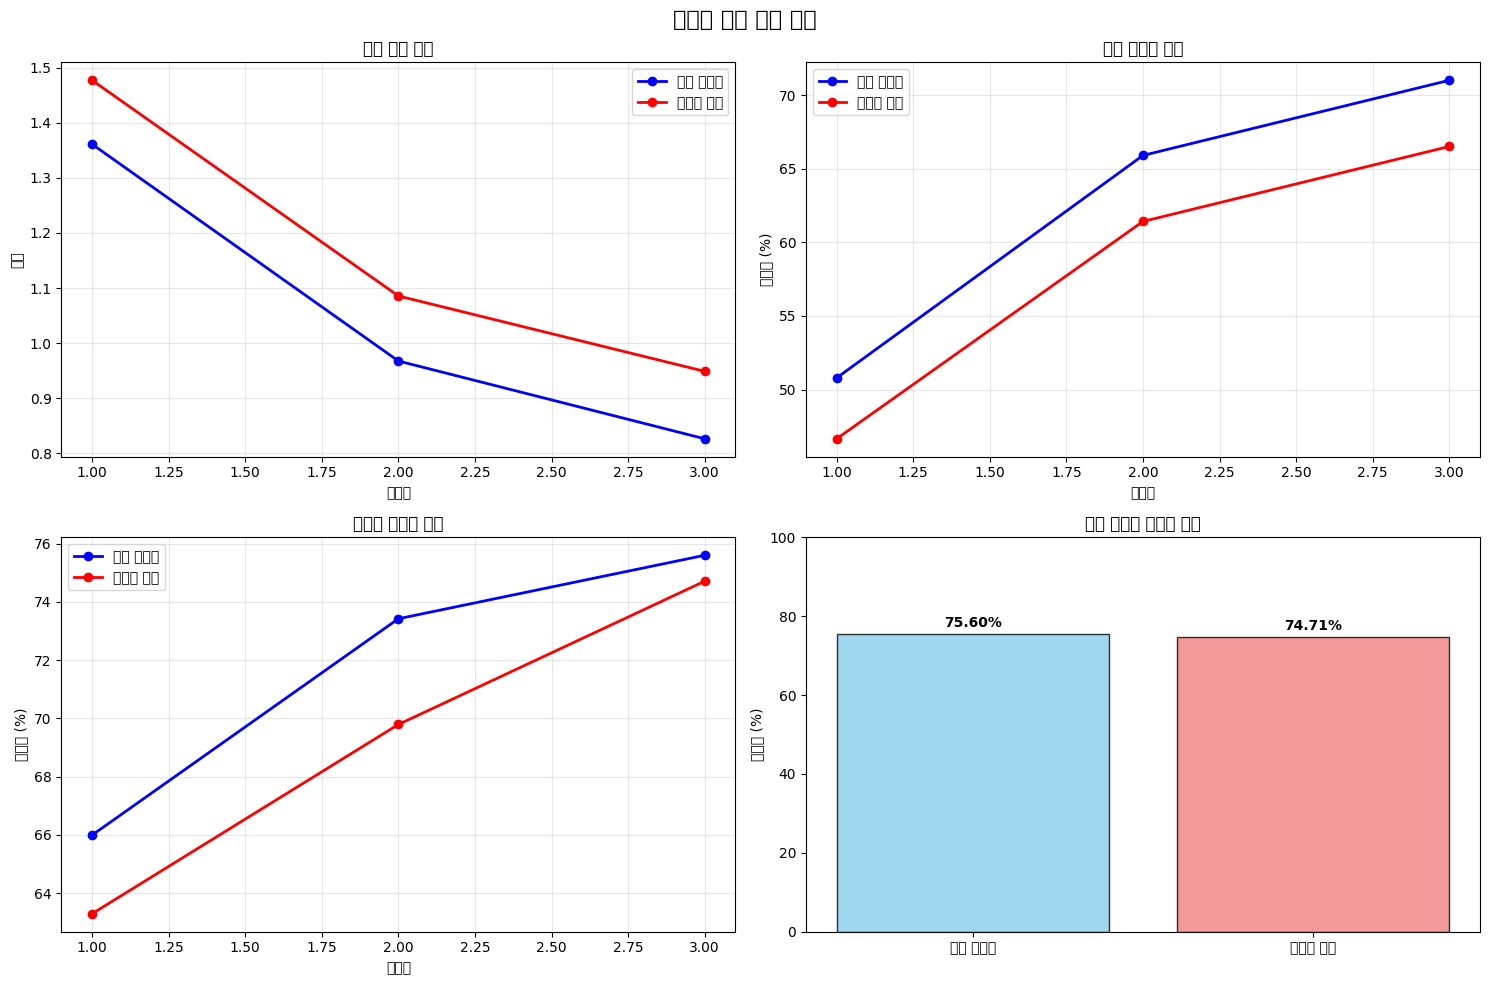

📈 그래프에서 데이터 증강의 효과를 확인해보세요!
💡 일반적으로 데이터 증강은 과적합을 줄이고 일반화 성능을 향상시킵니다.


In [9]:
# 📊 학습 결과 시각화
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('데이터 증강 효과 비교', fontsize=16, fontweight='bold')

epochs_range = range(1, len(basic_losses) + 1)

# 1. 훈련 손실 비교
ax1.plot(epochs_range, basic_losses, 'b-o', label='기본 전처리', linewidth=2)
ax1.plot(epochs_range, aug_losses, 'r-o', label='데이터 증강', linewidth=2)
ax1.set_title('훈련 손실 비교')
ax1.set_xlabel('에포크')
ax1.set_ylabel('손실')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 훈련 정확도 비교
ax2.plot(epochs_range, basic_train_acc, 'b-o', label='기본 전처리', linewidth=2)
ax2.plot(epochs_range, aug_train_acc, 'r-o', label='데이터 증강', linewidth=2)
ax2.set_title('훈련 정확도 비교')
ax2.set_xlabel('에포크')
ax2.set_ylabel('정확도 (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 테스트 정확도 비교
ax3.plot(epochs_range, basic_test_acc, 'b-o', label='기본 전처리', linewidth=2)
ax3.plot(epochs_range, aug_test_acc, 'r-o', label='데이터 증강', linewidth=2)
ax3.set_title('테스트 정확도 비교')
ax3.set_xlabel('에포크')
ax3.set_ylabel('정확도 (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 최종 성능 막대 그래프
methods = ['기본 전처리', '데이터 증강']
final_accs = [final_basic_acc, final_aug_acc]
colors = ['skyblue', 'lightcoral']

bars = ax4.bar(methods, final_accs, color=colors, alpha=0.8, edgecolor='black')
ax4.set_title('최종 테스트 정확도 비교')
ax4.set_ylabel('정확도 (%)')
ax4.set_ylim(0, 100)

# 막대 위에 정확도 값 표시
for bar, acc in zip(bars, final_accs):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("📈 그래프에서 데이터 증강의 효과를 확인해보세요!")
print("💡 일반적으로 데이터 증강은 과적합을 줄이고 일반화 성능을 향상시킵니다.")


## 6. 강의 정리 및 마무리

### 🎯 오늘 배운 핵심 내용

1. **🔧 이미지 전처리의 중요성**
   - 일관성 확보, 학습 효율성 향상, 성능 개선
   - Resize, Normalize, ToTensor 등 기본 기법들

2. **🎨 데이터 증강(Data Augmentation)**
   - 기존 데이터로 새로운 훈련 데이터 생성
   - 과적합 방지와 일반화 성능 향상
   - RandomHorizontalFlip, RandomRotation, ColorJitter 등

3. **📊 실제 성능 비교**
   - CIFAR-10 데이터셋으로 실험
   - 기본 전처리 vs 데이터 증강 효과 확인
   - 시각화를 통한 결과 분석

### 💡 실무 적용 팁

1. **🎯 적절한 증강 기법 선택**
   - 데이터 특성에 맞는 증강 기법 적용
   - 과도한 증강은 오히려 성능 저하 가능

2. **⚖️ 균형있는 접근**
   - 훈련 시에만 증강 적용
   - 테스트 시에는 일관된 전처리만 사용

3. **🔄 점진적 접근**
   - 기본 전처리부터 시작
   - 단계적으로 증강 기법 추가

### 📝 다음 강의 예고
14강에서는 CNN 성능 최적화와 하이퍼파라미터 튜닝에 대해 알아보겠습니다!
